# Setup

In [1]:
!pip install transformers

In [2]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import T5ForConditionalGeneration, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
!nvidia-smi

Fri Dec 22 23:35:25 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Create Training Set


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
# os.chdir("drive/My Drive/CS505-Project/data")
os.chdir("drive/My Drive/other")

In [5]:
!ls

gen_hitler.txt	       hitler.json	  joe_biden.json       t5-outputs
george_washinton.json  hitler_model_save  john_f_kennedy.json  wash_model_save


In [ ]:
# def combinejson(json_files, filename):
#   # Create an empty list to store the Python objects.
#   python_objects = []

#   # Load each JSON file into a Python object.
#   for json_file in json_files:
#       with open(json_file, "r") as f:
#           python_objects.append(json.load(f))

#   # Dump all the Python objects into a single JSON file.
#   with open(filename+".json", "w") as f:
#       json.dump(python_objects, f, indent=4)


In [ ]:
# import json
# from collections import defaultdict

# all_dict =defaultdict(list)

# # Create a list of all the JSON files that you want to combine.
# # all_dict['Abe'] = ['Abe1.json', 'Abe2.json', 'Abe3.json', 'Abe4.json', 'Abe5.json']
# # all_dict['WC'] = ['WC1.json', 'WC2.json', 'WC3.json', 'WC4.json', 'WC5.json']
# all_dict['Hillary'] = ['hillaryclinton1.json', 'hillaryclinton3.json', 'hillaryclinton2.json', 'hillaryclinton4.json', 'hillaryclinton5.json']
# # all_dict['Obama'] = ['obama1.json', 'obama2.json', 'obama3.json', 'obama4.json', 'obama5.json']
# # all_dict['Trump'] = ['trump_1.json', 'trump2.json', 'trump3.json', 'trump4.json', 'trump5.json']

# for key in all_dict:
#   combinejson(all_dict[key], key)


In [ ]:
# import json

# all_data = defaultdict()

# for key in all_dict:

#   f = open(key+'.json')

#   all_data[key] = json.load(f)

#   f.close()

In [ ]:
# print(all_data['Hillary'])

[{'Person': 'Hillary Clinton', 'Title': "Hillary Clinton's concession speech", 'Date': 'November 9, 2016', 'Text': 'Thank you. Thank you all. Thank you. Thank you all very much. Thank you. Thank you. Thank you so much. Very rowdy group. Thank you, my friends. Thank you. Thank you, thank you so very much for being here and I love you all, too. Last night, I congratulated Donald Trump and offered to work with him on behalf of our country. I hope that he will be a successful president for all Americans. This is not the outcome we wanted or we worked so hard for and I’m sorry that we did not win this election for the values we share and the vision we hold for our country. But I feel pride and gratitude for this wonderful campaign that we built together, this vast, diverse, creative, unruly, energized campaign. You represent the best of America and being your candidate has been one of the greatest honors of my life. I know how disappointed you feel because I feel it too, and so do tens of m

# Other data files code

In [6]:
import json
json_file = 'george_washinton.json'
with open(json_file, "r") as f:
    all_data = json.load(f)

In [7]:
abe_l=[]

for i in all_data['Items']:
  abe_l.append(i['transcript'])

In [8]:
len(abe_l)

21

In [9]:
ds=[]
for i in abe_l[:5]:
  ds.append(i.split("."))

docs = []
for i in ds:
  for j in i:
    docs.append(j)

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

<ipython-input-10-0dc1d487ac7d>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<Axes: ylabel='Density'>

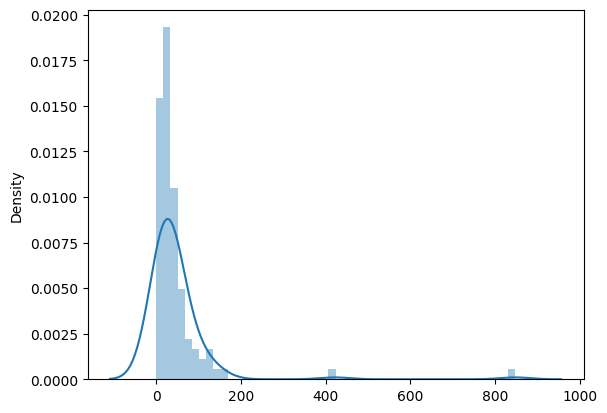

In [10]:
doc_lengths = []

for doc in docs:

    # get rough token count distribution
    tokens = nltk.word_tokenize(doc)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [11]:
# the max token length
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.009345794392523364

In [12]:
np.average(doc_lengths)

47.77570093457944

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most lines will be fit under the 768 embedding size limit for the small GPT2 model.

# T5 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens.

In [6]:
# Load the T5 tokenizer.
tokenizer = AutoTokenizer.from_pretrained("t5-small", bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')


In [14]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 512 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 32100
The end of sequence token <|endoftext|> has the id 32101
The padding token <|pad|> has the id 32102


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [15]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [16]:
class T5Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each line in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the line is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens.

If the line is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [17]:
dataset = T5Dataset(docs, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

   96 training samples
   11 validation samples


In [18]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [19]:
# I'm not really doing anything with the config buheret
# configuration = GPT2Config.from_pretrained('t5-small', output_hidden_states=False)

# instantiate the model
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [20]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [21]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [22]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [23]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [25]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            # for i, sample_output in enumerate(sample_outputs):
                  # print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...

  Average training loss: 24.85
  Training epoch took: 0:00:16

Running Validation...
  Validation Loss: 13.88
  Validation took: 0:00:01

======== Epoch 2 / 5 ========
Training...

  Average training loss: 7.41
  Training epoch took: 0:00:15

Running Validation...
  Validation Loss: 3.73
  Validation took: 0:00:01

======== Epoch 3 / 5 ========
Training...

  Average training loss: 2.85
  Training epoch took: 0:00:14

Running Validation...
  Validation Loss: 1.79
  Validation took: 0:00:01

======== Epoch 4 / 5 ========
Training...

  Average training loss: 1.76
  Training epoch took: 0:00:14

Running Validation...
  Validation Loss: 1.31
  Validation took: 0:00:01

======== Epoch 5 / 5 ========
Training...

  Average training loss: 1.47
  Training epoch took: 0:00:15

Running Validation...
  Validation Loss: 1.19
  Validation took: 0:00:01

Training complete!
Total training took 0:01:16 (h:mm:ss)


Let's view the summary of the training process.

In [26]:
# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,24.85,13.88,0:00:16,0:00:01
2,7.41,3.73,0:00:15,0:00:01
3,2.85,1.79,0:00:14,0:00:01
4,1.76,1.31,0:00:14,0:00:01
5,1.47,1.19,0:00:15,0:00:01


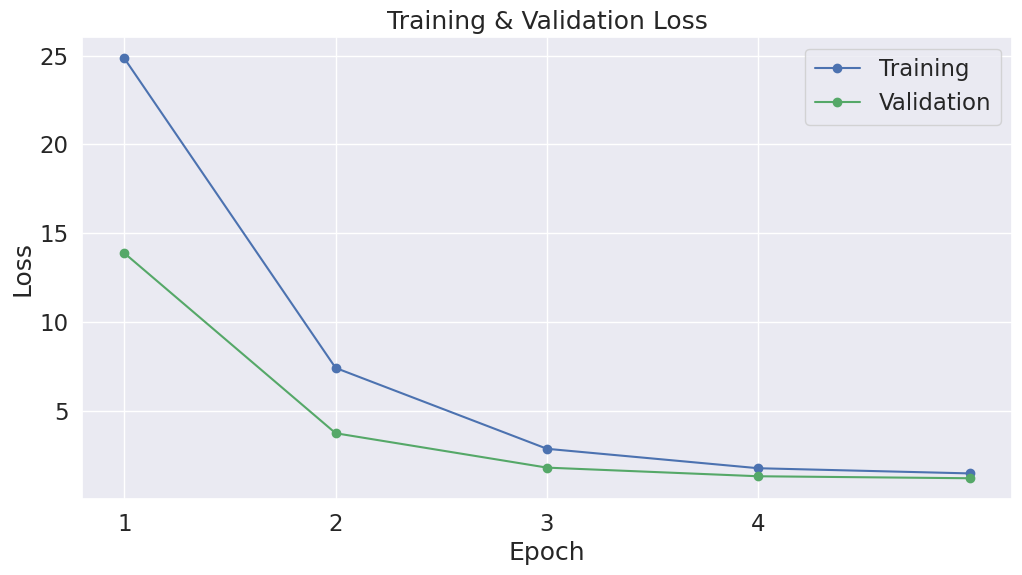

In [27]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [29]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The T5 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The T5 model has 131 different named parameters.

==== Embedding Layer ====

shared.weight                                           (32103, 512)
encoder.block.0.layer.0.SelfAttention.q.weight            (512, 512)

==== First Transformer ====

encoder.block.0.layer.0.SelfAttention.k.weight            (512, 512)
encoder.block.0.layer.0.SelfAttention.v.weight            (512, 512)
encoder.block.0.layer.0.SelfAttention.o.weight            (512, 512)
encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight      (32, 8)
encoder.block.0.layer.0.layer_norm.weight                     (512,)
encoder.block.0.layer.1.DenseReluDense.wi.weight         (2048, 512)
encoder.block.0.layer.1.DenseReluDense.wo.weight         (512, 2048)
encoder.block.0.layer.1.layer_norm.weight                     (512,)
encoder.block.1.layer.0.SelfAttention.q.weight            (512, 512)
encoder.block.1.layer.0.SelfAttention.k.weight            (512, 512)
encoder.block.1.layer.0.SelfAttention.v.weight      

# Saving & Loading Fine-Tuned Model


In [30]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './wash5_model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./wash5_model_save/


('./wash5_model_save/tokenizer_config.json',
 './wash5_model_save/special_tokens_map.json',
 './wash5_model_save/tokenizer.json')

In [31]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [32]:
!ls -l --block-size=K ./model_save/

ls: cannot access './model_save/': No such file or directory


# Generate Text

In [33]:
!ls

gen_hitler.txt	       hitler.json	  joe_biden.json       t5-outputs	 wash_model_save
george_washinton.json  hitler_model_save  john_f_kennedy.json  wash5_model_save


In [25]:
model = T5ForConditionalGeneration.from_pretrained("wash5_model_save")
model.eval()

prompt = "America is"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
# generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=50,
                                max_length = 100,
                                top_p=0.95,
                                num_return_sequences=10
                                )
ops = []
for i, sample_output in enumerate(sample_outputs):
  ops.append(sample_output)
  # print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

tensor([[1371,   19,    1]])


In [26]:
gen_text=[]
for i in ops:
  gen_text.append(tokenizer.decode(i, skip_special_tokens=True))

In [27]:
abe= " ".join(gen_text)

In [28]:
abe

'Minnesota est Beide America is the only member state Amérique est Am Amerika ist Spirit Spirit Spirit America All He has Beideamerikan); der Reihe America State Senator Billboardboard is a member of the Northeast America is where it is the first time she lives Amerika ist Amérique are obsessed with'

In [ ]:
!pwd

In [ ]:
with open("t5-outputs/gen_wash.txt", "w", encoding='utf-8') as f:
  f.write(abe)